#Análise de Sentimentos e Modelagem de Tópicos de avaliações da Lojas Americanas

A base de dados foi obtida através desse link: https://github.com/b2wdigital/b2w-reviews01

Ela contém mais de 130 mil avaliações de clientes coletadas do site de comércio eletrônico da Americanas.com entre janeiro e maio de 2018.
Com base nessas avaliações, espera-se que seja possível fazer uma análise de sentimentos e criar um classificador automatico. Também será feito uma modelagem de tópicos em cima desses dados.

#**Leitura e Pré-Processamento dos dados**

**Importação dos pacotes necessários**

In [ ]:
!pip install nltk
import pandas as pd
import spacy
import seaborn as sns
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('rslp')

!python -m spacy download pt
from spacy.lang.pt.stop_words import STOP_WORDS

**Leitura da base de dados**

In [ ]:
link = "https://drive.google.com/u/1/uc?id=1J-EDzR3bRg5-P-O9l0I5Wjk_5WdeZmOG&export=download" #Base de dados CSV salvo no Google Drive
base = pd.read_csv(link, sep=";")
base = base[["product_name","site_category_lv1","site_category_lv2","overall_rating","recommend_to_a_friend","review_text"]]
base = base.query("recommend_to_a_friend == 'Yes' or recommend_to_a_friend == 'No'")
print(base.sample(10))

                                             product_name  ...                                        review_text
56765   Espátula e Raspador de bolo e Massas 15cm (Ino...  ...  Ajuda muito na preparação de pães e massas em ...
101580  Confeitaria Escalafobética: Sobremesas Explica...  ...  Lindo, fofo, maravilhoso, didático, fotografia...
108580                     Livro - O Sucesso Está em Você  ...  otimo livro, entrega antes do prazo, gostei mu...
107846  Toner Samsung D111 D111s Mlt-D111s M2020 M2070...  ...  O produto entrega o que promete, 5% de uma fol...
21677   Som Portátil Philco PB119L CD Player Rádio AM/...  ...  Por esse preço se compra algo melhor, não indi...
27520   Compressor de Ar Naveg com 3 Bicos Adaptadores...  ...  eu recomendo aos meus amigos e muito bom esse ...
53348    Grill e Sanduicheira Mondial Mac Grill S-11 Inox  ...  Gostei muito. Funciona certinho. Pão fica tost...
7791    Smartphone Motorola Moto G 5S Dual Chip Androi...  ...  Gostei muito do smartpho

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Pré-processamento dos dados**

Será passado para minúsculo todas as letras dos textos, assim como da remoção de letras que se repetem três vezes ou mais, como no caso da avaliação conter palavras escritas como 'boooommm', sendo substituida por apenas 'bom', também serão removidos os caracteres especiais e por fim, será feito a tokenização e a remoção das stopwords da lingua portuguesa.


In [ ]:
review_text_trat = []
stop_words = stopwords.words('portuguese')

for aval in base["review_text"]:
    aval = aval.lower()
    aval = re.sub(r'[^\w\s]','',aval)
    aval = re.sub(r'(.)\1{2,}', r'\1',aval)  #Remoção de letras que se repetem 3x ou mais
    aval = re.sub(r'/[^a-zA-Z]/g',"",aval)  #Remoção de caracteres especiais
    aval = nltk.word_tokenize(aval)  #tokenização
    sem_stop = []
    #remoção das stopwords
    for pal in aval:
        if pal not in stop_words:
            sem_stop.append(pal)
    review_text_trat.append(sem_stop)

**Realizando o steamming dos comentários.**

In [ ]:
stematizer = RSLPStemmer()
review_text_stem = []

for aval in review_text_trat:
    st = [stematizer.stem(word) for word in aval]
    review_text_stem.append(st)

print("Algumas avaliações com o steamming: ")
for x in range(100,110):
    print(review_text_stem[x])

base["review_text"]=review_text_stem

Algumas avaliações com o steamming: 
['compr', 'pen', 'driv', 'imag', 'condiz', 'produt', 'vei', 'outr', 'model']
['aind', 'receb', 'ped', 'muit', 'irrespons', 'loj', 'coloc', 'entreg', 'aind', 'nao', 'receb', 'nad']
['rop', 'cumpr', 'promet', 'dev', 'dar', 'muit', 'atenç', 'uso', 'bat', 'prolong', 'vid', 'útil', 'mesm']
['excel', 'produt', 'esquent', 'dá', 'format', 'desej', 'ador', 'recom']
['básic', 'gost', 'menos', 'apar', 'propagand', 'retrat', 'produt']
['bom', 'produt', 'feliz', 'seman', '2018', 'chei', 'am', 'alegr', 'grand', 'realiz']
['ador', 'recom', 'tod', 'perfeit', 'proteç', 'mot', 'detalh', 'produt', 'cheg', 'ant', 'praz', 'perfeit', 'proteg', 'continu', 'imperme', 'sup', 'recom', 'ha', 'detalh', 'marid', 'qu', 'compr', 'pra']
['bom', 'produtogel', 'med', 'certafácil', 'ental']
['câm', 'wif', 'anunci', 'tod', 'acessóri', 'const', 'descr', 'fot', 'vêm', 'câm']
['celul', 'fant', 'rápid', 'muit', 'capac', 'lev', 'tir', 'fot', 'alt', 'qual', 'fácil', 'us']


#**Análise de Sentimentos**

Para análisar se uma avaliação é positiva ou não, será utilizado os dados contidos na coluna "recommend_to_a_friend", pois se a avaliação for positiva ou negativa, pode-se deduzir que o autor dela irá recomendar ou não o produto à alguem respectivamente.

Dessa forma, iremos separar essas duas colunas em duas bases, uma para treinar o algoritmo, e a outra pra testar a acuracia do mesmo.

In [ ]:
analise = base[["recommend_to_a_friend","review_text"]]

treino, teste = train_test_split(analise) #Separação em duas bases de dados

treino = treino.values.tolist()
teste = teste.values.tolist()

Por questões de implementação, os tokens das duas bases serão transformados em texto corrido novamente

In [ ]:
#BASE DE TREINO
frases_treino = []
classificacao_treino = []
for linha in treino:
    frase = ""
    for palavra in linha[1]:
        frase = frase + " " + palavra
    frases_treino.append(frase)
    classificacao_treino.append(linha[0])

In [ ]:
#BASE DE TESTE
frases_teste = []
classificacao_teste = []
for linha in teste:
    frase = ""
    for palavra in linha[1]:
        frase = frase + " " + palavra
    frases_teste.append(frase)
    classificacao_teste.append(linha[0])


**Construção da matriz termo-documento com o CountVectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
counter_vectorizer = CountVectorizer(min_df=15)

counts = counter_vectorizer.fit_transform(frases_treino)
counts

<99266x3705 sparse matrix of type '<class 'numpy.int64'>'
	with 1189559 stored elements in Compressed Sparse Row format>

**Construção da matriz termo-documento com o método TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=15)

tfidf = tfidf_vectorizer.fit_transform(frases_treino)
tfidf

<99266x3705 sparse matrix of type '<class 'numpy.float64'>'
	with 1189559 stored elements in Compressed Sparse Row format>

**Comparação gráfica entre os dois métodos**

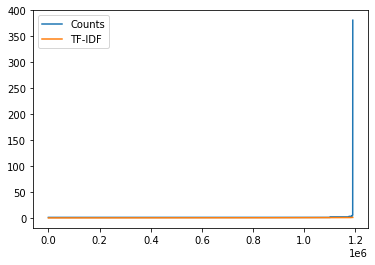

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sorted(counts.data),label="Counts");
plt.plot(sorted(tfidf.data),label="TF-IDF");
plt.legend();

**Treinamento dos classificadores com o algoritmo de Floresta Aleatória**-

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_counts = RandomForestClassifier(n_estimators=100, random_state=15)
clf_counts.fit(counts, classificacao_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [ ]:
clf_tfidf = RandomForestClassifier(n_estimators=100, random_state=15)
clf_tfidf.fit(tfidf, classificacao_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

**Os 15 termos mais importantes segundo a classificação feita**

In [ ]:
nwords = 15
counts_importance_idx = clf_counts.feature_importances_.argsort()[-nwords:]
tfidf_importance_idx = clf_tfidf.feature_importances_.argsort()[-nwords:]

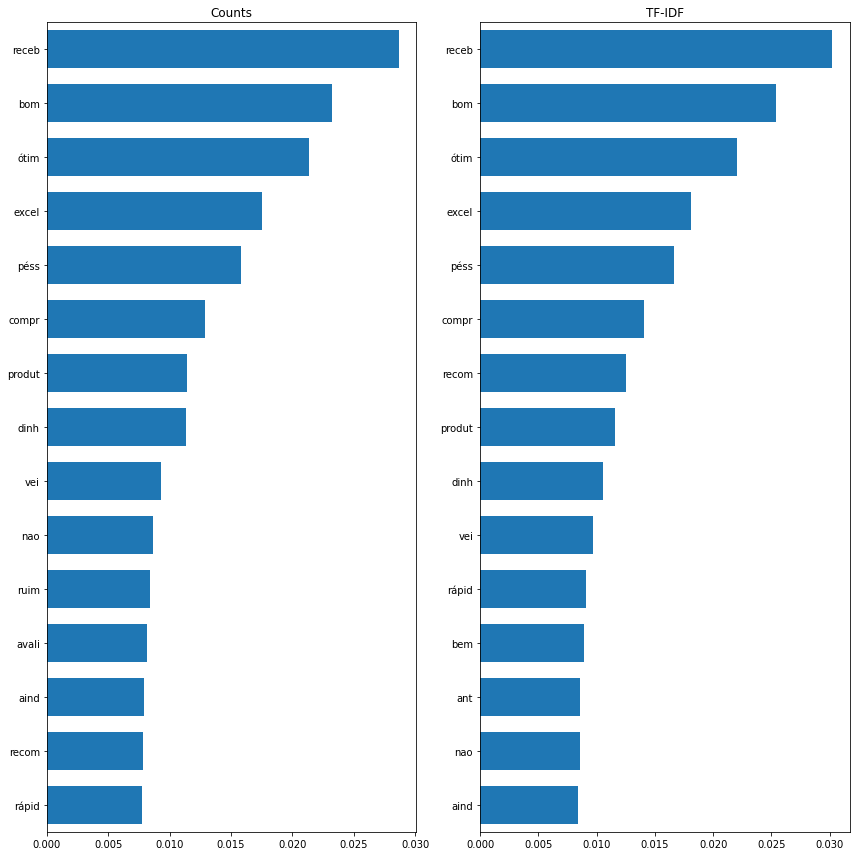

In [ ]:
import numpy as np

# variavel para ajustar os plots
tree_indices = np.arange(0, nwords) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.barh(tree_indices,
         clf_counts.feature_importances_[counts_importance_idx], height=0.7)
ax1.set_yticklabels(np.array(counter_vectorizer.get_feature_names())[counts_importance_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, nwords))
ax1.set_title("Counts")

ax2.barh(tree_indices,
         clf_tfidf.feature_importances_[tfidf_importance_idx], height=0.7)
ax2.set_yticklabels(np.array(tfidf_vectorizer.get_feature_names())[tfidf_importance_idx])
ax2.set_yticks(tree_indices)
ax2.set_ylim((0, nwords))
ax2.set_title("TF-IDF")

fig.tight_layout()
plt.show()

Nota-se que as top-5 palavras consideradas serão "recebi", "bom", "péssimo", "ótimo" e "excelente"

**Palavras que só aparecem em um dos modelos**

In [ ]:
counts_importance_terms = set(np.array(counter_vectorizer.get_feature_names())[counts_importance_idx])
tfidf_importance_terms = set(np.array(tfidf_vectorizer.get_feature_names())[tfidf_importance_idx])

In [ ]:
counts_importance_terms - tfidf_importance_terms

{'avali', 'ruim'}

In [ ]:
tfidf_importance_terms - counts_importance_terms

{'ant', 'bem'}

No método usando a contagem, temos as palavras únicas "avaliação" e "ruim". Já no método TF-IDF, temos "bem" e "antes"

**Analise de desempenho dos classificadores**

Será utilizado as palavras "No" para as avaliações negativas, e "Yes" para as positivas

**Classificador Count**

              precision    recall  f1-score   support

          No       0.83      0.75      0.79      8970
         Yes       0.91      0.94      0.93     24119

    accuracy                           0.89     33089
   macro avg       0.87      0.85      0.86     33089
weighted avg       0.89      0.89      0.89     33089



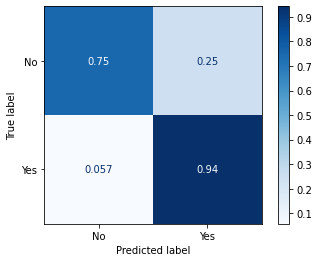

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, classification_report

pipeline_counts = Pipeline([
    ('vect', counter_vectorizer),
    ('clf', clf_counts)
])

plot_confusion_matrix(pipeline_counts, frases_teste, classificacao_teste,display_labels=['No','Yes'],cmap=plt.cm.Blues,normalize='true');
print(classification_report(classificacao_teste, pipeline_counts.predict(frases_teste),zero_division=0))

**Classificador TF-IDF**

              precision    recall  f1-score   support

          No       0.83      0.77      0.79      8970
         Yes       0.92      0.94      0.93     24119

    accuracy                           0.89     33089
   macro avg       0.87      0.85      0.86     33089
weighted avg       0.89      0.89      0.89     33089



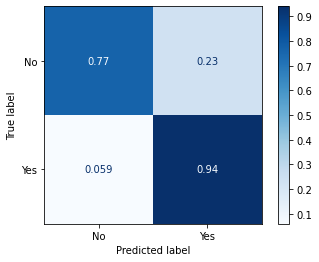

In [ ]:
pipeline_tfidf = Pipeline([
    ('vect', tfidf_vectorizer),
    ('clf', clf_tfidf)
])

plot_confusion_matrix(pipeline_tfidf, frases_teste, classificacao_teste,display_labels=['No','Yes'],cmap=plt.cm.Blues,normalize='true')
print(classification_report(classificacao_teste, pipeline_tfidf.predict(frases_teste),zero_division=0))

Com base nas avaliações dos dados obtidos, nota-se que o método da TF-IDF obteve uma pequena vantagem, em que a predição para comentarios negativos teve um resultado melhor que a predição feita pela contagem.

De forma geral, os dois classificadores tiveram resultados práticamente semelhantes, dessa forma, qualquer um dos dois podem ser utilizados para classificar automaticamente avaliações dessa natureza.

#Modelagem de tópicos (18)


##Modelagem com LDA

Importação das bibliotecas necessárias


In [ ]:
!pip install gensim
import pickle
import gensim
from collections import defaultdict
from gensim import corpora
!pip install pyLDAvis

**Carregamento dos dados de avaliações já pré-tratadas anteriormente**

In [ ]:
frequency = defaultdict(int)

aval = base["review_text"]

Análise de frequencia dos tokens, onde será usados somente os tokens que aparecerem mais de uma vez na base de dados

In [ ]:
for text in aval:
    for token in text:
        frequency[token] += 1

aval = [ [token for token in av if frequency[token]>1] for av in aval]

dictionary = corpora.Dictionary(aval)
corpus = [dictionary.doc2bow(av) for av in aval]

Criação da sacola de palavras e do dicionario

In [ ]:
pickle.dump(corpus, open('gensim_corpus_corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Criação do modelo LDA com 4 tópicos-

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=20)
lda_model.save('gensim_model.gensim')

Os 4 tópicos gerados

In [ ]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.048*"produt" + 0.044*"compr" + 0.029*"dia" + 0.025*"receb" + 0.019*"entreg" + 0.016*"americ" + 0.015*"aind" + 0.012*"loj" + 0.009*"ped" + 0.009*"sit"')
(1, '0.105*"produt" + 0.073*"entreg" + 0.054*"praz" + 0.053*"cheg" + 0.044*"recom" + 0.043*"ant" + 0.029*"rápid" + 0.029*"bom" + 0.027*"qual" + 0.023*"ótim"')
(2, '0.011*"fic" + 0.010*"compr" + 0.010*"ser" + 0.008*"outr" + 0.008*"pod" + 0.007*"vei" + 0.007*"pouc" + 0.006*"pra" + 0.006*"poi" + 0.006*"ach"')
(3, '0.050*"produt" + 0.045*"bom" + 0.030*"ótim" + 0.030*"recom" + 0.027*"qual" + 0.022*"excel" + 0.021*"bem" + 0.019*"boa" + 0.017*"atend" + 0.016*"gost"')


Avaliando o modelo

In [ ]:
print('\nPerplexity:', lda_model.log_perplexity(corpus))

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(model=lda_model, texts=aval, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)


Perplexity: -6.758544511920064

Coherence Score: 0.5338291776862851


Visualizando o modelo LDA

In [ ]:
gensim_dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
gensim_corpus = pickle.load(open('gensim_corpus_corpus.pkl', 'rb'))
lda_model = gensim.models.ldamodel.LdaModel.load('gensim_model.gensim')

import pyLDAvis.gensim

lda_visualization = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

##Modelagem com LSA

Carregamento dos dados de avaliações já pré-tratadas anteriormente e transformação dos tokens das avaliações em texto corrido

In [ ]:
pd.set_option("display.max_colwidth", 200)

aval = base["review_text"]

frases = []
for linha in aval:
    frase = ""
    for palavra in linha:
        frase = frase + " " + palavra
    frases.append(frase)

Criação da Matriz termo-documento com 500 termos

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features= 500,
                             max_df = 0.5, 
                             smooth_idf=True)

X = vectorizer.fit_transform(frases)

Modelagem dos tópicos

Decomposição da matriz

In [ ]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=4, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=4, n_iter=100,
             random_state=122, tol=0.0)

Impressão dos 4 tópicos, com as 10 palavras mais importantes de cada um

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")

Topic 0: 
produt
entreg
recom
bom
praz
ótim
cheg
qual
excel
ant
 
Topic 1: 
compr
receb
dia
aind
americ
nao
loj
avali
outr
pra
 
Topic 2: 
praz
ant
cheg
entreg
previst
receb
dia
americ
dentr
parabém
 
Topic 3: 
bom
cheg
ant
praz
atend
bem
gost
expect
necess
previst
 


Nos dois métodos, nota-se que o tema mais recorrente nos tópicos refere-se a entrega dos produtos

Por questões computacionais, não foi possível gerar a visualização gráfica do método LSA